In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf,plot_lines,plot_box_by_config,plot_box
from util.consts import balance_size_bins, balance_size_bins_label
from util.plot import color_list
import json
import os
from collections import defaultdict

flowsim-sldn: (1, 85588), actual_sldn: (1, 85588), sizes: (85588,)
new_loss01_mlp1_10-sldn: (1, 85588), actual_sldn: (1, 85588), sizes: (85588,)


/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


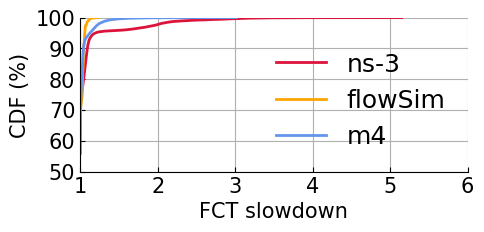

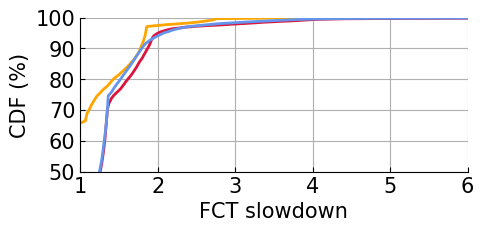

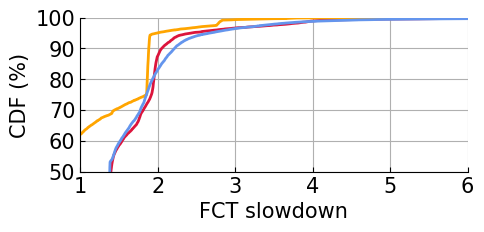

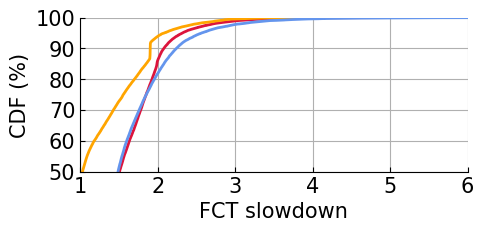

In [4]:
size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
legend_list=['ns-3','flowSim','m4']
model_instance_list=['flowsim',"new_loss01_mlp1_10"]
n_methods = len(legend_list)
fig_index=0
for scenario_idx in [0]:
    empirical_str = f"_large{scenario_idx}"
    
    sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data/{scenario_idx}/ns3/fsize.npy')

    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0]
        actual_sldns = sldn[:,:, 1]
        print(f"{model_instance}-sldn: {predicted_sldns.shape}, actual_sldn: {actual_sldns.shape}, sizes: {sizes.shape}")
        assert predicted_sldns.size == actual_sldns.size==sizes.size
        
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_cdf(plot_data,f'./figs/eva_large_scale_cdf_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=50,log_switch=False,xlim_bottom=1, fig_idx=fig_index,xlim=6)
        fig_index+=1

-----------------
flowsim_large0-sldn: (85588,)
p99 slowdown: 2.63869074761659, 3.325010334041024
new_loss01_mlp1_10_large0-sldn: (85588,)
p99 slowdown: 3.307126727104194, 3.325010334041024
mean error:[13.66592765042259, 4.819822301124581]
p99 error: [20.64112642  0.53785117]


/data1/lichenni/projects/per-flow-sim/util/plot.py:306: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:306: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


-----------------
flowsim_large1-sldn: (50788,)
p99 slowdown: 1.9803868636720396, 2.3886448469420163
new_loss01_mlp1_10_large1-sldn: (50788,)
p99 slowdown: 2.3401413774490347, 2.3886448469420163
mean error:[13.669938981268052, 3.207276962049891]
p99 error: [17.0916151   2.03058523]
-----------------
flowsim_large2-sldn: (92281,)
p99 slowdown: 2.435299607892364, 3.2627295299072308
new_loss01_mlp1_10_large2-sldn: (92281,)
p99 slowdown: 2.785667896270749, 3.2627295299072308
mean error:[8.835963526992032, 4.297547881371834]
p99 error: [25.36005251 14.62155012]


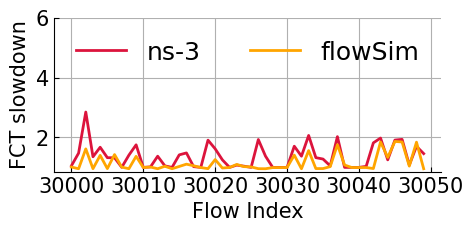

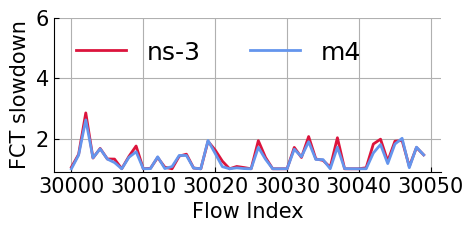

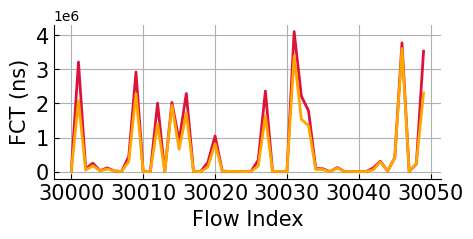

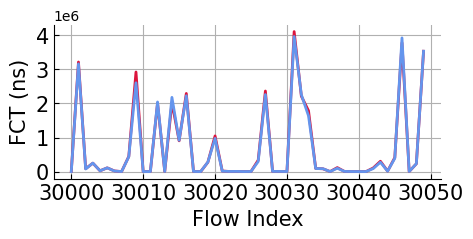

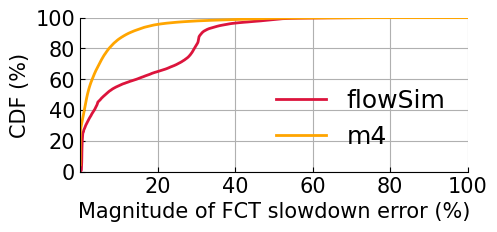

In [5]:
empirical_str = ""

legend_list=['flowSim','m4']
for scenario_idx,scenario_str in enumerate(["_large0","_large1","_large2"]):
    model_instance_list=[f'flowsim{scenario_str}',f'new_loss01_mlp1_10{scenario_str}']
    error_list=[]
    error_list_p99=[]
    sldn_list=[]
    fct_list=[]
    print(f"-----------------")
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0].squeeze()
        actual_sldns = sldn[:,:, 1].squeeze()
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        fct=data_m4['fct']
        predicted_fcts = fct[:, :, 0].squeeze()
        actual_fcts = fct[:,:, 1].squeeze()
        
        # calculate the relative error
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        sldn_list.append([actual_sldns,predicted_sldns])
        fct_list.append([actual_fcts,predicted_fcts])
        error_list.append(relative_error_sldn)
        
        sldn_p99_est=np.percentile(predicted_sldns,99)
        sldn_p99_act=np.percentile(actual_sldns,99)
        print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
        error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
    error_list=np.array(error_list)
    error_list_p99=np.array(error_list_p99)
    sldn_list=np.array(sldn_list)
    fct_list=np.array(fct_list)
    print(f"mean error:{[np.mean(x) for x in error_list]}")
    print(f"p99 error: {error_list_p99}")
    
    if scenario_idx==0:  
        fig_idx=0
        data_x=np.arange(30000, 30050)
        linelabels = [["ns-3","flowSim"],["ns-3","m4"]]
        format_idx=[[0,1],[0,2]]
        for i, (actual, predicted) in enumerate(sldn_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_sldn_{i}.pdf',
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT slowdown",
                title=None,
                ylim=6,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=18,
                fig_idx=fig_idx,
            )
            fig_idx+=1

        for i, (actual, predicted) in enumerate(fct_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_fct_{i}.pdf',
                [],
                x_label="Flow Index",
                y_label="FCT (ns)",
                title=None,
                # log_switch=True,
                # ylim=6,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=18,
                fig_idx=fig_idx,
            )
            fig_idx+=1
            
        plot_cdf(
            error_list,
            f'./figs/eva_large_scale_cdf.pdf',
            legend_list,
            x_label="Magnitude of FCT slowdown error (%)",
            log_switch=False,
            rotate_xaxis=False,
            xlim=100,
            xlim_bottom=0.01,
            fontsize=15,
            legend_font=18,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_idx
        )

flowsim-sldn: (100, 20000)
new_loss01_mlp1_10-sldn: (100, 20000)
worst idx: [64 65 49 41 26 63 57 17 68 52]
p99 error:[29.470826324191712, 23.076251964309673]
mean error:[13.508511277029257, 7.789664371708763]
median error:[11.33384600925967, 6.686010926423702]
p99 error:[29.234773649699395, 9.734088306350715]


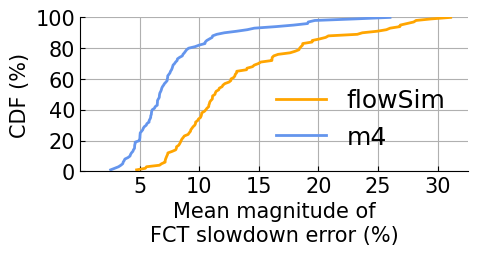

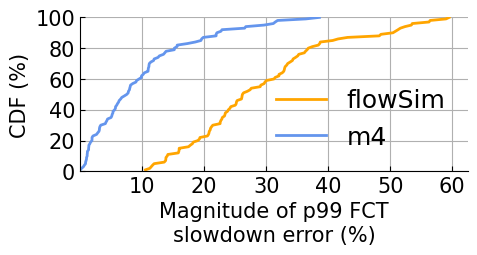

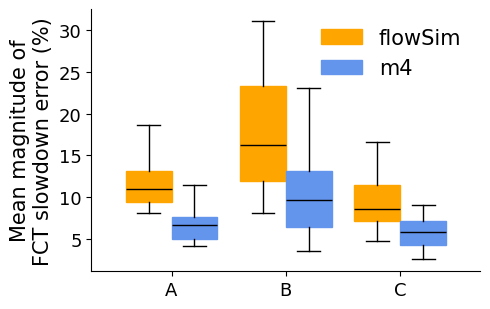

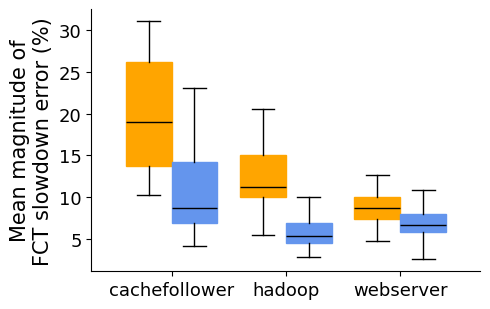

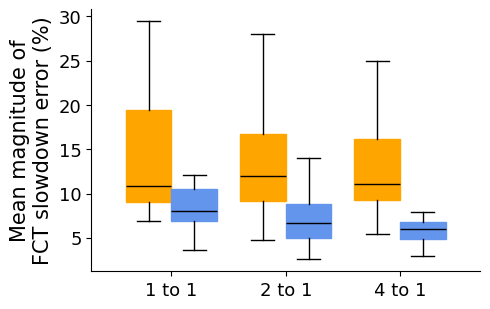

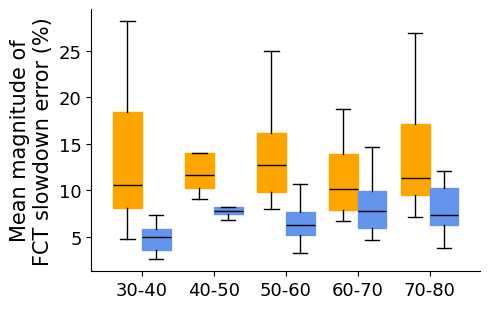

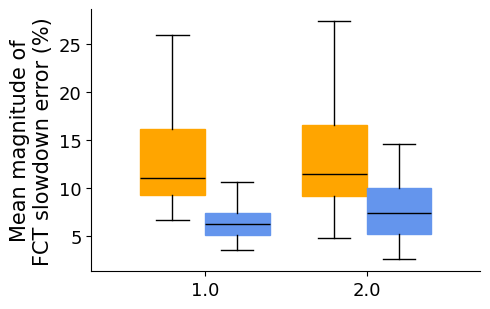

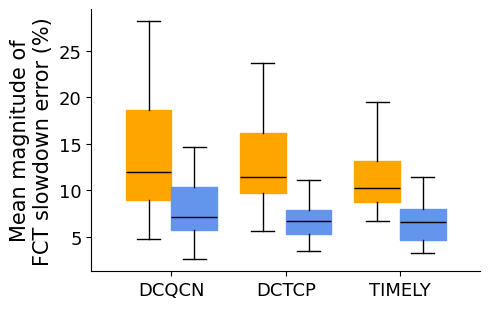

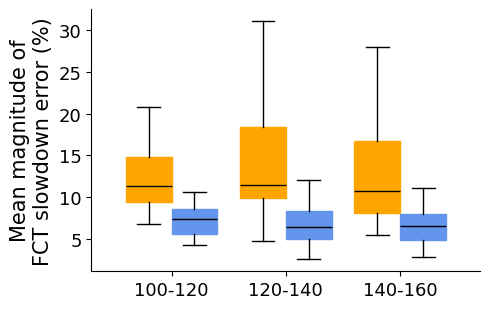

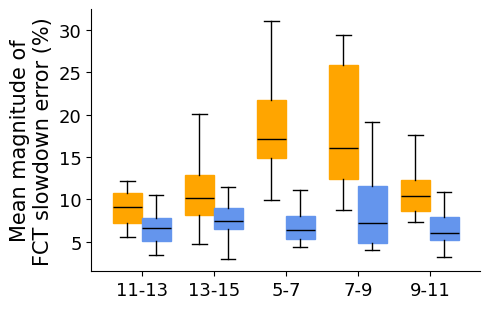

In [6]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4']
model_instance_list=['flowsim','new_loss01_mlp1_10']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

sorted_index=np.argsort(error_list[0])
print(f"worst idx: {sorted_index[-10:]}")
# print(f"worst perf: {error_list[2][sorted_index[-10:]]}, {error_list[1][sorted_index[-10:]]}")

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_cdf_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_cdf_p99.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3,0.4, 0.5, 0.6, 0.70,0.80]
labels = ['30-40', '40-50', '50-60', '60-70','70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,120,140,160,180]
labels = ['100-120', '120-140', '140-160', '160-180']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [5000,7000,9000,11000,13000,15000]
labels = ['5-7', '7-9', '9-11', '11-13', '13-15']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==0 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=f"figs/eva_box_{i}.pdf",y_label="Mean magnitude of\nFCT slowdown error (%)")
    fig_idx+=1

flowsim-sldn: (100, 20000)
new_loss01_mlp1_10-sldn: (100, 20000)
new_loss01_mlp1_nosize_9-sldn: (100, 20000)
new_loss01_mlp1_noqueue_9-sldn: (100, 20000)
new_loss01_mlp1_noflowsim_10-sldn: (100, 20000)
p99 error:[29.470826324191712, 23.076251964309673, 23.169651499755208, 22.31072263523939, 21.6841138006006]
mean error:[13.508511277029257, 7.789664371708763, 9.311822994545327, 9.15238681177109, 7.979052071053877]
median error:[11.33384600925967, 6.686010926423702, 8.157164292108522, 8.17101827659713, 7.0654928514420305]
p99 error:[29.234773649699395, 9.734088306350715, 14.531261841901692, 15.219585030111945, 11.183669818388466]


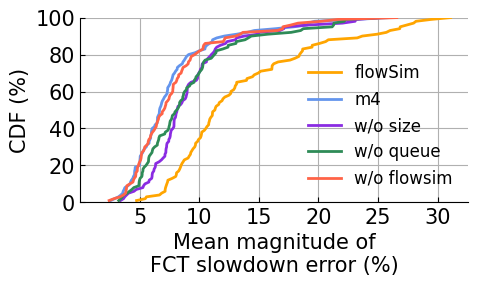

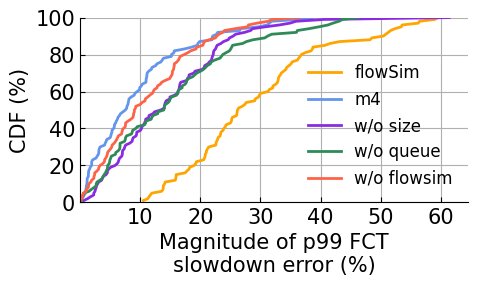

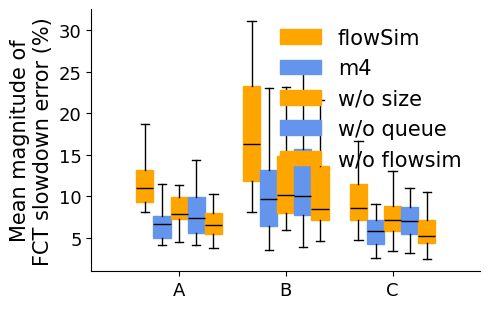

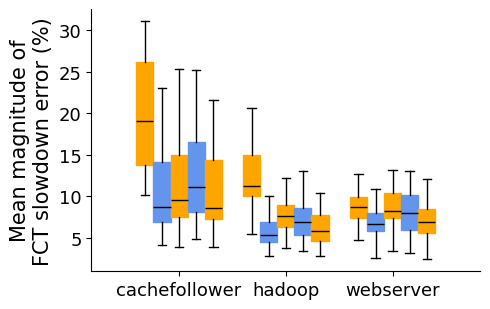

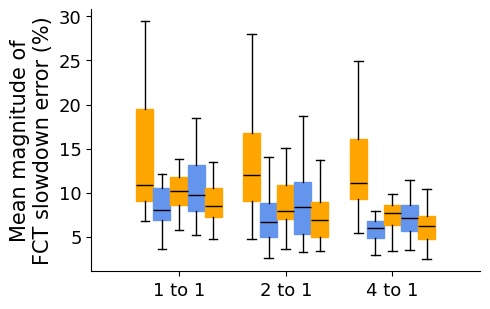

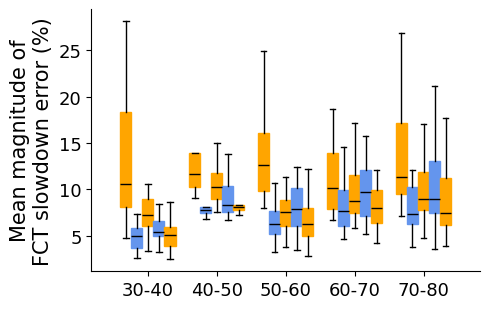

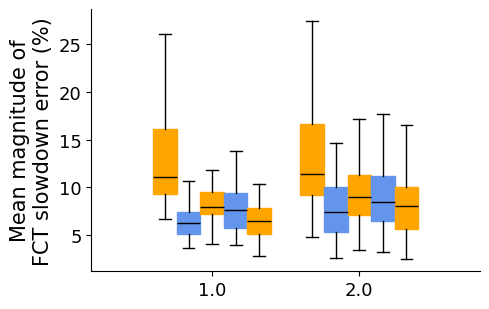

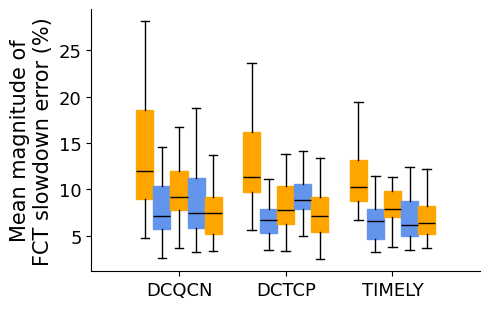

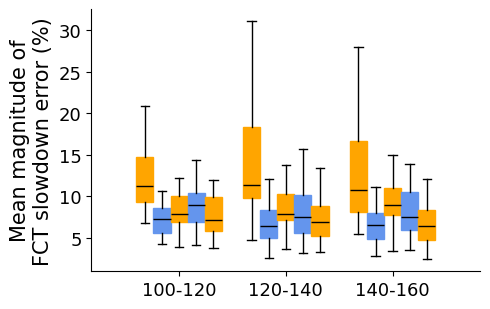

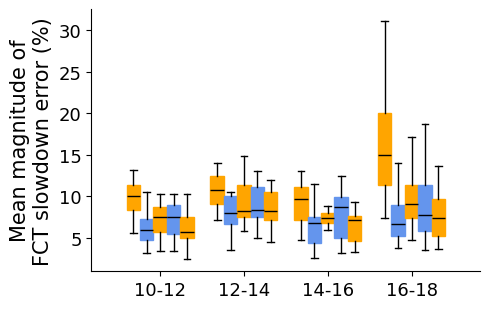

In [7]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4','w/o size','w/o queue','w/o flowsim']
model_instance_list=['flowsim','new_loss01_mlp1_10','new_loss01_mlp1_nosize_9','new_loss01_mlp1_noqueue_9','new_loss01_mlp1_noflowsim_10']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_ablation_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_ablation_p99.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato'],
    fig_idx=fig_idx,
    fig_size=(5,2.4)
)
fig_idx+=1

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['30-40', '40-50', '50-60', '60-70', '70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,120,140,160,180]
labels = ['100-120', '120-140', '140-160', '160-180']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000]
labels = ['10-12', '12-14', '14-16', '16-18']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==0 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=None,y_label="Mean magnitude of\nFCT slowdown error (%)")
    fig_idx+=1